LeFFA
===

**Learning Flow Fields in Attention for Controllable Person Image Generation**

 * Paper: https://arxiv.org/abs/2412.08486


![Leffa Overview](../assets/leffa_overview.png)




```bash
git clone https://github.com/franciszzj/Leffa.git
cd Leffa/


conda create -n leffa python==3.10
conda activate leffa
pip install -r requirements.txt 
pip install ipykernel
python -m ipykernel install --user --name leffa --display-name "leffa"
```

In [1]:
import sys
sys.path.append("Leffa_repo")
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download

from leffa.transform import LeffaTransform
from leffa.model import LeffaModel
from leffa.inference import LeffaInference
from leffa_utils.garment_agnostic_mask_predictor import AutoMasker
from leffa_utils.densepose_predictor import DensePosePredictor
from leffa_utils.utils import resize_and_center, list_dir, get_agnostic_mask_hd, get_agnostic_mask_dc, preprocess_garment_image
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose

/home/pyml/anaconda3/envs/leffa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download checkpoints

In [2]:
# Download checkpoints
snapshot_download(repo_id="franciszzj/Leffa", local_dir="./ckpts")

Fetching 37 files: 100%|██████████| 37/37 [00:00<00:00, 4076.53it/s]


'/home/pyml/git_vmirly/GenAI-Hub/tmp/Leffa/ckpts'

In [3]:
# code from Leffa repo
class LeffaPredictor(object):
    def __init__(self):
        self.mask_predictor = AutoMasker(
            densepose_path="./ckpts/densepose",
            schp_path="./ckpts/schp",
        )

        self.densepose_predictor = DensePosePredictor(
            config_path="./ckpts/densepose/densepose_rcnn_R_50_FPN_s1x.yaml",
            weights_path="./ckpts/densepose/model_final_162be9.pkl",
        )

        self.parsing = Parsing(
            atr_path="./ckpts/humanparsing/parsing_atr.onnx",
            lip_path="./ckpts/humanparsing/parsing_lip.onnx",
        )

        self.openpose = OpenPose(
            body_model_path="./ckpts/openpose/body_pose_model.pth",
        )

        vt_model_hd = LeffaModel(
            pretrained_model_name_or_path="./ckpts/stable-diffusion-inpainting",
            pretrained_model="./ckpts/virtual_tryon.pth",
            dtype="float16",
        )
        self.vt_inference_hd = LeffaInference(model=vt_model_hd)

        vt_model_dc = LeffaModel(
            pretrained_model_name_or_path="./ckpts/stable-diffusion-inpainting",
            pretrained_model="./ckpts/virtual_tryon_dc.pth",
            dtype="float16",
        )
        self.vt_inference_dc = LeffaInference(model=vt_model_dc)

        pt_model = LeffaModel(
            pretrained_model_name_or_path="./ckpts/stable-diffusion-xl-1.0-inpainting-0.1",
            pretrained_model="./ckpts/pose_transfer.pth",
            dtype="float16",
        )
        self.pt_inference = LeffaInference(model=pt_model)

    def leffa_predict(
        self,
        src_image_path,
        ref_image_path,
        control_type,
        ref_acceleration=False,
        step=50,
        scale=2.5,
        seed=42,
        vt_model_type="viton_hd",
        vt_garment_type="upper_body",
        vt_repaint=False,
        preprocess_garment=False
    ):
        # Open and resize the source image.
        src_image = Image.open(src_image_path)
        src_image = resize_and_center(src_image, 768, 1024)

        # For virtual try-on, optionally preprocess the garment (reference) image.
        if control_type == "virtual_tryon" and preprocess_garment:
            if isinstance(ref_image_path, str) and ref_image_path.lower().endswith('.png'):
                # preprocess_garment_image returns a 768x1024 image.
                ref_image = preprocess_garment_image(ref_image_path)
            else:
                raise ValueError("Reference garment image must be a PNG file when preprocessing is enabled.")
        else:
            # Otherwise, load the reference image.
            ref_image = Image.open(ref_image_path)
            
        ref_image = resize_and_center(ref_image, 768, 1024)

        src_image_array = np.array(src_image)

        if control_type == "virtual_tryon":
            src_image = src_image.convert("RGB")
            model_parse, _ = self.parsing(src_image.resize((384, 512)))
            keypoints = self.openpose(src_image.resize((384, 512)))
            if vt_model_type == "viton_hd":
                mask = get_agnostic_mask_hd(model_parse, keypoints, vt_garment_type)
            elif vt_model_type == "dress_code":
                mask = get_agnostic_mask_dc(model_parse, keypoints, vt_garment_type)
            mask = mask.resize((768, 1024))
        elif control_type == "pose_transfer":
            mask = Image.fromarray(np.ones_like(src_image_array) * 255)

        if control_type == "virtual_tryon":
            if vt_model_type == "viton_hd":
                src_image_seg_array = self.densepose_predictor.predict_seg(src_image_array)[:, :, ::-1]
                src_image_seg = Image.fromarray(src_image_seg_array)
                densepose = src_image_seg
            elif vt_model_type == "dress_code":
                src_image_iuv_array = self.densepose_predictor.predict_iuv(src_image_array)
                src_image_seg_array = src_image_iuv_array[:, :, 0:1]
                src_image_seg_array = np.concatenate([src_image_seg_array] * 3, axis=-1)
                src_image_seg = Image.fromarray(src_image_seg_array)
                densepose = src_image_seg
        elif control_type == "pose_transfer":
            src_image_iuv_array = self.densepose_predictor.predict_iuv(src_image_array)[:, :, ::-1]
            src_image_iuv = Image.fromarray(src_image_iuv_array)
            densepose = src_image_iuv

        transform = LeffaTransform()
        data = {
            "src_image": [src_image],
            "ref_image": [ref_image],
            "mask": [mask],
            "densepose": [densepose],
        }
        data = transform(data)
        if control_type == "virtual_tryon":
            if vt_model_type == "viton_hd":
                inference = self.vt_inference_hd
            elif vt_model_type == "dress_code":
                inference = self.vt_inference_dc
        elif control_type == "pose_transfer":
            inference = self.pt_inference
        output = inference(
            data,
            ref_acceleration=ref_acceleration,
            num_inference_steps=step,
            guidance_scale=scale,
            seed=seed,
            repaint=vt_repaint,
        )
        gen_image = output["generated_image"][0]
        return np.array(gen_image), np.array(mask), np.array(densepose)

    def leffa_predict_vt(self, src_image_path, ref_image_path, ref_acceleration, step, scale, seed, vt_model_type, vt_garment_type, vt_repaint, preprocess_garment):
        return self.leffa_predict(
            src_image_path,
            ref_image_path,
            "virtual_tryon",
            ref_acceleration,
            step,
            scale,
            seed,
            vt_model_type,
            vt_garment_type,
            vt_repaint,
            preprocess_garment,  # Pass through the new flag.
        )

    def leffa_predict_pt(self, src_image_path, ref_image_path, ref_acceleration, step, scale, seed):
        return self.leffa_predict(
            src_image_path,
            ref_image_path,
            "pose_transfer",
            ref_acceleration,
            step,
            scale,
            seed,
        )

In [4]:
leffa_predictor = LeffaPredictor()
leffa_predictor

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [5]:
# virtual try-on example
# input : ../samples/man.jpg
# ref image: ../samples/suit.png
res = leffa_predictor.leffa_predict_vt(
    src_image_path="../samples/man.jpg",
    ref_image_path="../samples/suit.png",
    ref_acceleration=False,
    step=50,
    scale=2.5,
    seed=42,
    vt_model_type="viton_hd",
    vt_garment_type="upper_body",
    vt_repaint=False,
    preprocess_garment=True
)

len(res), res[0].shape, res[1].shape, res[2].shape

100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
/home/pyml/anaconda3/envs/leffa/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/50 [00:00<?, ?it/s]/home/pyml/anaconda3/envs/leffa/lib/python3.10/site-packages/diffusers/models/resnet.py:323: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)
/home/pyml/anaconda3/envs/leffa/lib/python3.10/site-packages/diffusers/models/activations.py:116: FutureWarning: `sca

(3, (1024, 768, 3), (1024, 768), (1024, 768, 3))

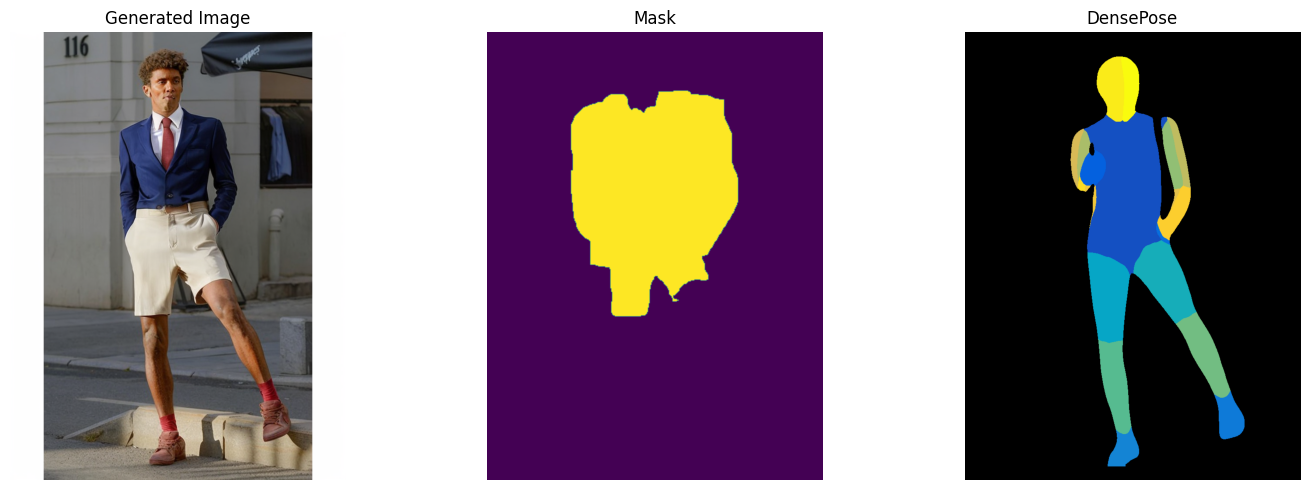

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
axes = axes.ravel()
axes[0].imshow(res[0])
axes[0].set_title("Generated Image")
axes[1].imshow(res[1])
axes[1].set_title("Mask")
axes[2].imshow(res[2])
axes[2].set_title("DensePose")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()